
Initializing Environment with SEED: 42
Total minimal energy required (Optimal): 16.92 kJ
Determined State Shape: (14,)
Advanced DQN Agent Initialized.
Traditional DQN Agent Initialized.

--- Starting Training for Advanced DQN ---
Energy Budget (1.5x Optimal): 169.16 kJ
Optimal Minimal Energy Required: 16.92 kJ
Error: Invalid action 2 received in step function. Max action index is 1.
Error: Invalid action 2 received in step function. Max action index is 1.
Error: Invalid action 2 received in step function. Max action index is 1.
Error: Invalid action 2 received in step function. Max action index is 1.
Error: Invalid action 2 received in step function. Max action index is 1.
Error: Invalid action 2 received in step function. Max action index is 1.
Error: Invalid action 2 received in step function. Max action index is 1.
Error: Invalid action 2 received in step function. Max action index is 1.
Error: Invalid action 2 received in step function. Max action index is 1.
Error: Invalid action

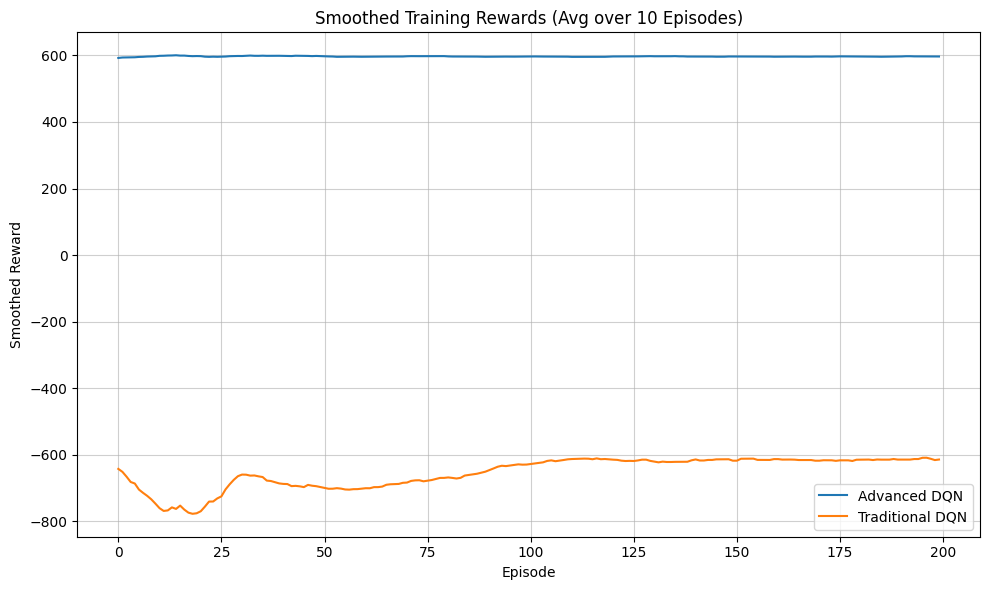

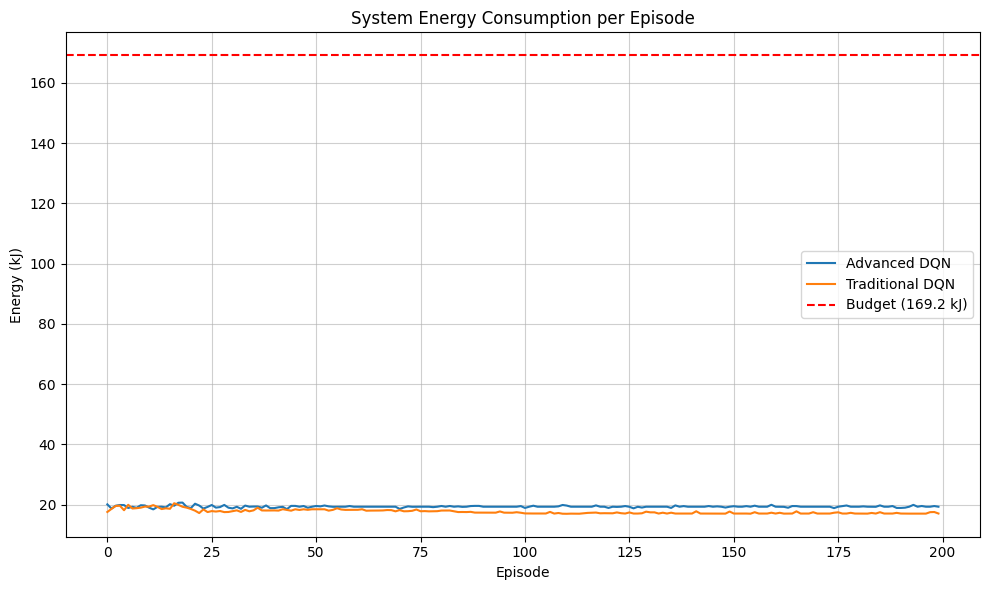

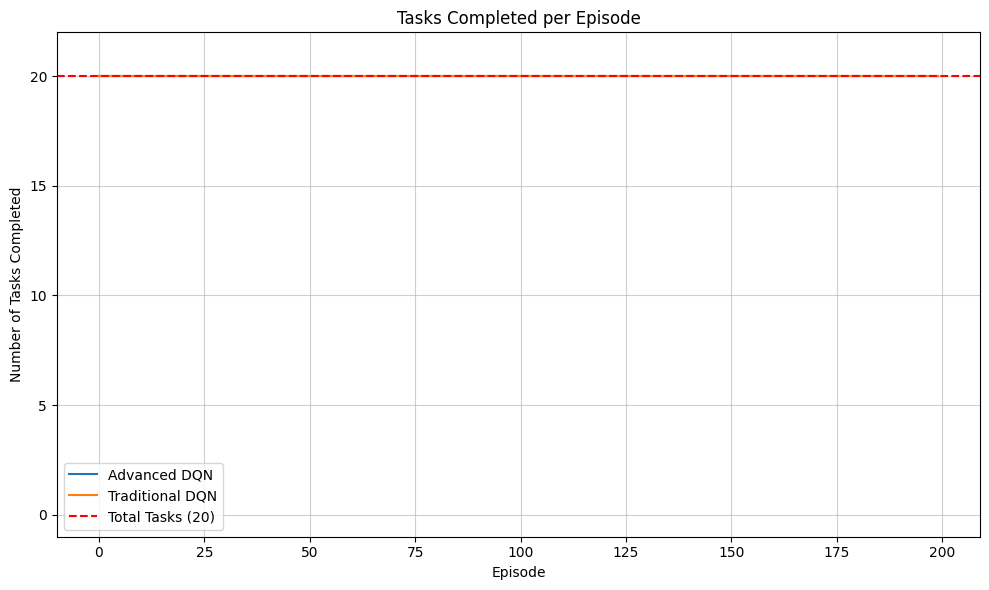


--- End of Script ---


In [4]:
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import psutil
import time
import random
import os
import copy # Needed for deep copying environment state if necessary
import traceback # For detailed error logging

# --- Seeding for Reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# Optional: for more determinism, though might impact performance slightly
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['TF_CUDNN_DETERMINISM'] = '1'

# --- Energy Tracker ---
class EnergyTracker:
    def __init__(self):
        self.CPU_TDP = 45  # Watts (Typical TDP for a laptop CPU)
        self.start_time = None

    def start(self):
        self.start_time = time.time()
        # Call cpu_percent once at the start to initialize interval measurement
        try:
            psutil.cpu_percent(interval=None)
        except Exception as e:
             print(f"Warning: psutil cpu_percent init failed: {e}")


    def stop(self):
        if self.start_time is None:
            return {"cpu_j": 0, "total_j": 0, "duration": 0}

        duration = time.time() - self.start_time
        try:
            # Get CPU usage over the tracked duration
            avg_cpu_usage = psutil.cpu_percent(interval=None) / 100
        except Exception as e:
             # print(f"Warning: psutil cpu_percent failed during stop: {e}") # Can be noisy
             avg_cpu_usage = 0.2 # Estimate if psutil fails

        cpu_energy = self.CPU_TDP * avg_cpu_usage * duration
        self.start_time = None # Reset start time after stopping
        return {
            "cpu_j": cpu_energy,
            "total_j": cpu_energy, # Currently only tracks CPU
            "duration": duration
        }

# --- Prioritized Replay Buffer ---
class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.capacity = int(capacity) # Ensure capacity is integer
        self.buffer = deque(maxlen=self.capacity) # Use deque for efficient appends/pops
        # Initialize priorities as float64 for precision in calculations
        self.priorities = np.zeros(self.capacity, dtype=np.float64)
        self.pos = 0
        self.max_priority = 1.0
        self.alpha = 0.6 # Fixed priority exponent
        self.beta_start = 0.4 # Initial importance sampling exponent
        self.beta_frames = 100000 # Anneal beta over this many samples seen

    def add(self, experience):
        priority = self.max_priority # Use max priority for new experiences
        current_size = len(self.buffer)

        if current_size < self.capacity:
             idx = current_size # Next available index
             self.buffer.append(experience) # Append to deque
             self.priorities[idx] = priority
             self.pos = (idx + 1) % self.capacity # Update position for next add if buffer becomes full
        else:
             # Buffer is full, overwrite oldest element at self.pos
             idx = self.pos
             # Deque handles removal of oldest automatically when maxlen is reached on append
             self.buffer.append(experience) # This shifts elements if full
             # Update priority at the correct index (which is now the end after append shifts)
             # Or, simpler: overwrite the priority at the oldest position before it gets conceptually overwritten
             self.priorities[idx] = priority
             self.pos = (self.pos + 1) % self.capacity

        self.max_priority = max(self.max_priority, priority) # Keep track of global max


    def sample(self, batch_size, frame_idx):
        buffer_len = len(self.buffer)
        if buffer_len < batch_size: # Should not happen if replay starts after buffer > batch_size
            # print(f"Warning: Trying to sample {batch_size} elements, but buffer only has {buffer_len}")
            return [], [], [] # Cannot sample

        # Sample only from filled part of priorities array
        if buffer_len == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:buffer_len]

        # Add small epsilon to probabilities to ensure non-zero chance for all
        # Use float64 for probabilities calculation
        probs = (prios + 1e-6) ** self.alpha # Add epsilon before exponentiation
        probs = np.array(probs, dtype=np.float64) # Ensure float64

        # Check for invalid probabilities (e.g., sum is zero or NaN)
        sum_probs = probs.sum()
        if sum_probs <= 0 or np.isnan(sum_probs) or np.isinf(sum_probs):
             print(f"Warning: Invalid probability sum ({sum_probs}). Sampling uniformly.")
             # Fallback to uniform sampling
             indices = np.random.choice(buffer_len, batch_size, replace=True)
             probs = np.ones(buffer_len) / buffer_len # Uniform probabilities for weight calculation
        else:
             probs /= sum_probs # Normalize probabilities
             try:
                  indices = np.random.choice(buffer_len, batch_size, p=probs, replace=True)
             except ValueError as e:
                   print(f"Error sampling from buffer (ValueError): {e}")
                   print(f"Buffer length: {buffer_len}, Batch size: {batch_size}")
                   print(f"Probabilities sum: {np.sum(probs)}")
                   # print(f"Probabilities array: {probs}") # Avoid printing large arrays unless debugging
                   # Fallback: Sample uniformly if probabilities are invalid
                   indices = np.random.choice(buffer_len, batch_size, replace=True)
                   probs = np.ones(buffer_len) / buffer_len # Uniform probabilities for weight calculation

        samples = [self.buffer[idx] for idx in indices]

        # Anneal beta
        beta = min(1.0, self.beta_start + frame_idx * (1.0 - self.beta_start) / self.beta_frames)

        # Calculate importance sampling weights using float64
        weights = (buffer_len * probs[indices]) ** (-beta)
        weights /= weights.max() # Normalize for stability
        weights = np.array(weights, dtype=np.float32) # Cast back to float32 for TF

        return samples, indices, weights

    def update_priorities(self, indices, priorities_new):
        priorities_new = np.abs(priorities_new) + 1e-5 # Add small epsilon for stability and non-zero priority
        for idx, priority in zip(indices, priorities_new):
             # Ensure index is within the current buffer size bounds
             if idx < self.capacity: # Check against capacity, not len(buffer) if using fixed array
                  self.priorities[idx] = priority
                  self.max_priority = max(self.max_priority, priority)
             else:
                 # This case should ideally not happen with correct index management
                 print(f"Warning: Attempted to update priority for index {idx} outside buffer capacity {self.capacity}")

# --- MEC Environment (Unified) ---
class MECEnvironment:
    def __init__(self, num_md=3, num_es=2, num_tasks=10, seed=None):
        # Use provided seed or generate one if None
        self._seed = seed if seed is not None else random.randint(0, 1_000_000)
        self._np_random_state = np.random.RandomState(self._seed)
        self._random_state = random.Random(self._seed) # Use separate random instance for non-numpy randomness

        self.state_shape = None
        self.num_md = num_md
        self.num_es = num_es
        self.num_tasks = num_tasks
        self.VOLTAGE_MD = 3.7 # Volts
        self.VOLTAGE_ES = 12.0 # Volts
        self.MAH_TO_J = 3.6 # Conversion factor: mAh * V * 3.6 = Joules
        self.operations_per_mb = 1e9 # Giga-operations per MB of task size (simplified)

        # --- Generate parameters using the seeded random state ---
        print(f"\nInitializing Environment with SEED: {self._seed}")
        self.md_compute = self._np_random_state.uniform(1.5, 3.5, num_md) # Giga-ops per second (GHz)
        self.es_compute = self._np_random_state.uniform(25.0, 35.0, num_es) # Giga-ops per second (GHz)
        self.task_requirements = self._np_random_state.randint(150, 600, num_tasks) # Task sizes in MB
        self.task_to_md = self._np_random_state.randint(0, num_md, num_tasks) # Which MD originates each task
        self.md_energy_local = self._np_random_state.uniform(4.0, 10.0, num_md) # W (Power consumption during local compute)
        self.md_energy_tx = self._np_random_state.uniform(0.6, 1.2, num_md) # W (Power consumption during transmission)
        self.es_energy_process = self._np_random_state.uniform(35.0, 65.0, num_es) # W (Power consumption during edge compute)

        # Simplified transmission time factor (can be randomized per MD-ES pair later)
        self.tx_time_per_mb = 0.1 # seconds per MB (example constant rate)

        # --- Calculate optimal energy and actions ---
        self.optimal_actions = []
        self.optimal_task_energies = np.zeros(num_tasks) # Store optimal energy per task
        self.md_energy_required_optimal = np.zeros(num_md) # Total optimal energy used by each MD
        self.es_energy_required_optimal = np.zeros(num_es) # Total optimal energy used by each ES

        for task_idx in range(num_tasks):
            md_idx = self.task_to_md[task_idx]
            task_size = self.task_requirements[task_idx]
            compute_ops = task_size * self.operations_per_mb # Total operations for the task

            # Local processing energy (Energy = Power * Time = Power * Ops / Compute_Speed)
            local_energy = float('inf') # Default to infinity if compute speed is too low
            if self.md_compute[md_idx] > 1e-9: # Avoid division by zero or near-zero
                 local_time = compute_ops / (self.md_compute[md_idx] * 1e9) # time in seconds
                 local_energy = self.md_energy_local[md_idx] * local_time

            # Find minimal offload energy
            min_offload_energy = float('inf')
            best_es = -1
            tx_energy_for_best_es = 0 # Track Tx energy for the chosen optimal ES

            for es_idx in range(num_es):
                 # Tx Energy = Power * Time = Power * Size * Time_per_MB
                 tx_energy = self.md_energy_tx[md_idx] * task_size * self.tx_time_per_mb

                 # Processing energy on ES
                 process_energy = float('inf')
                 if self.es_compute[es_idx] > 1e-9:
                      process_time = compute_ops / (self.es_compute[es_idx] * 1e9)
                      process_energy = self.es_energy_process[es_idx] * process_time

                 total_offload_energy = tx_energy + process_energy
                 if total_offload_energy < min_offload_energy:
                    min_offload_energy = total_offload_energy
                    best_es = es_idx
                    tx_energy_for_best_es = tx_energy # Store Tx energy for this best option


            # Decide optimal action and store energy
            if local_energy <= min_offload_energy:
                self.optimal_actions.append(0) # 0 for local
                self.optimal_task_energies[task_idx] = local_energy
                if local_energy != float('inf'):
                    self.md_energy_required_optimal[md_idx] += local_energy
            else:
                self.optimal_actions.append(best_es + 1) # 1 to num_es for edge servers
                self.optimal_task_energies[task_idx] = min_offload_energy
                # Account for energy spent by MD (Tx) and ES (Processing) if not infinite
                if min_offload_energy != float('inf'):
                    self.md_energy_required_optimal[md_idx] += tx_energy_for_best_es
                    if best_es != -1:
                        # Ensure process energy isn't negative if tx_energy > min_offload (shouldn't happen)
                        process_energy_optimal = max(0, min_offload_energy - tx_energy_for_best_es)
                        self.es_energy_required_optimal[best_es] += process_energy_optimal


        self.minimal_total_energy = np.sum([e for e in self.optimal_task_energies if e != float('inf')])
        print(f"Total minimal energy required (Optimal): {self.minimal_total_energy / 1000:.2f} kJ")

        # Battery history deque
        self.md_battery_history = deque(maxlen=3)
        self.es_battery_history = deque(maxlen=3)

        # Set budget and initialize state
        self.energy_budget = self.minimal_total_energy * 10 # 150% budget
        self.reset()

    def reset(self):
        # Resetting the environment state for a new episode
        # print(f"\nResetting Environment. Energy Budget: {self.energy_budget / 1000:.2f} kJ")

        # Allocate budget (50/50 split)
        md_total_budget = self.energy_budget * 0.5
        es_total_budget = self.energy_budget * 0.5

        # Calculate per-device energy budget in Joules
        md_energy_per_device = md_total_budget / self.num_md if self.num_md > 0 else 0
        es_energy_per_device = es_total_budget / self.num_es if self.num_es > 0 else 0

        # Initial battery levels in Joules
        self.initial_md_battery_j = np.full(self.num_md, md_energy_per_device, dtype=float)
        self.initial_es_battery_j = np.full(self.num_es, es_energy_per_device, dtype=float)

        # Current battery levels in Joules (start full)
        self.md_battery = self.initial_md_battery_j.copy()
        self.es_battery = self.initial_es_battery_j.copy()

        # Initialize task tracking and energy usage for the episode
        self.current_task = 0
        self.completed_tasks = 0
        self.violations = 0 # Count energy constraint violations
        self.total_energy_consumed = 0 # Track energy consumed in this episode
        self.local_task_count = 0
        self.edge_task_count = 0

        # Initialize battery history
        self.md_battery_history.clear()
        self.es_battery_history.clear()
        # Only append if batteries are valid numpy arrays
        if isinstance(self.md_battery, np.ndarray):
            self.md_battery_history.append(self.md_battery.copy())
        if isinstance(self.es_battery, np.ndarray):
            self.es_battery_history.append(self.es_battery.copy())

        return self._get_state()

    def _get_state(self):
        # If episode is done, return a zero state
        if self.current_task >= self.num_tasks:
            if self.state_shape:
                return np.zeros(self.state_shape, dtype=np.float32)
            else:
                # Calculate expected state size if shape not yet determined
                # 7 MD features + num_es * 5 ES features + 2 system features
                fallback_size = 7 + self.num_es * 5 + 2
                return np.zeros(fallback_size, dtype=np.float32)

        # Get info for the current task
        try:
            md_idx = self.task_to_md[self.current_task]
            task_size = self.task_requirements[self.current_task]
        except IndexError:
             print(f"Error: current_task index {self.current_task} out of bounds for tasks.")
             # Return a zero state or handle appropriately
             return np.zeros(self.state_shape, dtype=np.float32) if self.state_shape else np.zeros(7 + self.num_es * 5 + 2, dtype=np.float32)


        # Normalize based on INITIAL battery capacity in Joules
        # Add epsilon to avoid division by zero if initial capacity is 0
        # Ensure initial battery arrays are valid before accessing
        if md_idx < len(self.initial_md_battery_j):
             max_md_energy_j = self.initial_md_battery_j[md_idx] if self.initial_md_battery_j[md_idx] > 1e-6 else 1.0
        else:
            print(f"Warning: Invalid md_idx {md_idx} for initial_md_battery_j access.")
            max_md_energy_j = 1.0 # Fallback

        initial_es_energies_j = self.initial_es_battery_j.copy()
        initial_es_energies_j[initial_es_energies_j <= 1e-6] = 1.0 # Avoid division by zero for ES too

        # --- Battery Trends ---
        md_trend = 0.0
        # Check history length and valid index before calculating trend
        if len(self.md_battery_history) > 1 and md_idx < self.num_md:
             try:
                  # Average percentage change over history relative to initial capacity
                  changes = [(self.md_battery_history[i][md_idx] - self.md_battery_history[i-1][md_idx]) / max_md_energy_j
                             for i in range(1, len(self.md_battery_history))
                             if md_idx < len(self.md_battery_history[i]) and md_idx < len(self.md_battery_history[i-1])] # Index check
                  md_trend = np.mean(changes) if changes else 0.0
             except IndexError:
                  print(f"Warning: IndexError calculating MD battery trend for md_idx {md_idx}.")
                  md_trend = 0.0 # Fallback on error


        # --- State Vector Construction ---
        # Ensure current battery array is valid before access
        current_md_battery = 0.0
        if md_idx < len(self.md_battery):
            current_md_battery = self.md_battery[md_idx]

        initial_md_battery_val = 0.0
        if md_idx < len(self.initial_md_battery_j):
             initial_md_battery_val = self.initial_md_battery_j[md_idx]


        state = [
            # Mobile device features (Normalized)
            current_md_battery / max_md_energy_j,           # Current battery %
            (current_md_battery - initial_md_battery_val) / max_md_energy_j, # Battery depletion % from start
            self.md_compute[md_idx] / 3.5,                      # Compute capacity (norm ~0-1)
            task_size / 600.0,                                  # Task size (norm ~0-1)
            self.md_energy_local[md_idx] / 10.0,                # Local processing power (norm ~0-1)
            self.md_energy_tx[md_idx] / 1.2,                    # Tx power (norm ~0-1)
            md_trend,                                           # Battery trend (avg % change)
        ]

        # Edge server features (Normalized)
        for es_idx in range(self.num_es):
            # Check index validity before accessing arrays
            if es_idx < len(initial_es_energies_j) and es_idx < len(self.es_battery) and es_idx < len(self.initial_es_battery_j):
                 max_es_energy_j = initial_es_energies_j[es_idx]
                 current_es_battery = self.es_battery[es_idx]
                 initial_es_battery_val = self.initial_es_battery_j[es_idx]

                 es_trend_idx = 0.0
                 if len(self.es_battery_history) > 1:
                     try:
                         changes = [(self.es_battery_history[i][es_idx] - self.es_battery_history[i-1][es_idx]) / max_es_energy_j
                                    for i in range(1, len(self.es_battery_history))
                                    if es_idx < len(self.es_battery_history[i]) and es_idx < len(self.es_battery_history[i-1])] # Index check
                         es_trend_idx = np.mean(changes) if changes else 0.0
                     except IndexError:
                           print(f"Warning: IndexError calculating ES battery trend for es_idx {es_idx}.")
                           es_trend_idx = 0.0 # Fallback


                 state.extend([
                     current_es_battery / max_es_energy_j,        # Current battery %
                     (current_es_battery - initial_es_battery_val) / max_es_energy_j, # Battery depletion % from start
                     self.es_compute[es_idx] / 35.0,                   # Compute capacity (norm ~0-1)
                     self.es_energy_process[es_idx] / 65.0,            # Processing power (norm ~0-1)
                     es_trend_idx                                      # Battery trend % change
                 ])
            else:
                 print(f"Warning: Invalid es_idx {es_idx} during state construction. Appending zeros.")
                 # Append zeros or default values if index is invalid
                 state.extend([0.0] * 5)


        # System-wide features (Normalized)
        state.extend([
            self.current_task / self.num_tasks,                      # Task progress %
            self.total_energy_consumed / self.energy_budget if self.energy_budget > 1e-6 else 0.0 # Budget usage %
        ])

        state_array = np.array(state, dtype=np.float32)

        # Determine state shape on first valid call
        expected_size = 7 + self.num_es * 5 + 2
        if state_array.size != expected_size:
             print(f"Warning: State array size mismatch! Expected {expected_size}, Got {state_array.size}. Padding/truncating.")
             # Pad with zeros or truncate if size is wrong
             state_array = np.resize(state_array, (expected_size,))
             state_array = np.nan_to_num(state_array, nan=0.0, posinf=1.0, neginf=-1.0) # Clean again after resize


        if self.state_shape is None and state_array.size == expected_size:
            self.state_shape = state_array.shape
            print(f"Determined State Shape: {self.state_shape}")
        elif self.state_shape is None:
             print(f"Warning: Could not determine state shape. State size was {state_array.size}, expected {expected_size}")


        # Handle potential NaN/Inf values resulting from calculations or invalid inputs
        state_array = np.nan_to_num(state_array, nan=0.0, posinf=1.0, neginf=-1.0)


        return state_array

    # --- Step function with reward strategy selection ---
    def step(self, action, reward_strategy='advanced'):
        if self.current_task >= self.num_tasks:
            return self._get_state(), 0, True, {} # Episode already finished

        # Validate action index
        if not (0 <= action < 1 + self.num_es):
             print(f"Error: Invalid action {action} received in step function. Max action index is {self.num_es}.")
             # Handle invalid action -> Treat as failure? Return error state?
             # For now, let's treat as failure and don't change state, return negative reward
             info = {"file_info": {"file_size_MB": self.task_requirements[self.current_task],
                                   "task_index": self.current_task,
                                   "processed_at": f"Failed (Invalid Action {action})",
                                   "energy_used_J": 0,
                                   "task_completed": False},
                     "reward_step": -50.0} # Significant penalty
             # Don't advance task, return current state (or next state if preferred)
             # next_state = self._get_state() # Recalculate state based on unchanged batteries
             # return next_state, -50.0, False, info # Keep done=False if tasks remain
             # Simpler: Just return current state and mark done if this error shouldn't happen
             return self._get_state(), -50.0, True, info # End episode on error


        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        compute_ops = task_size * self.operations_per_mb
        energy_used_this_step = 0
        task_completed_flag = False
        info = {"file_info": {"file_size_MB": task_size,
                              "task_index": self.current_task}}
        reward = 0.0

        optimal_energy_this_task = self.optimal_task_energies[self.current_task]
        info["file_info"]["optimal_energy_J"] = optimal_energy_this_task

        try:
            # --- Action Execution ---
            if action == 0:  # Local processing
                energy_needed = float('inf')
                if self.md_compute[md_idx] > 1e-9:
                     local_time = compute_ops / (self.md_compute[md_idx] * 1e9)
                     energy_needed = self.md_energy_local[md_idx] * local_time

                # Check battery safety
                if md_idx < len(self.md_battery) and self.md_battery[md_idx] >= energy_needed:
                    self.md_battery[md_idx] -= energy_needed
                    energy_used_this_step = energy_needed
                    task_completed_flag = True
                    self.local_task_count += 1
                    info["file_info"]["processed_at"] = f"MD{md_idx}"
                elif md_idx >= len(self.md_battery):
                     print(f"Error: Invalid md_idx {md_idx} accessing MD battery.")
                     self.violations += 1
                     info["file_info"]["processed_at"] = "Failed (MD Idx Error)"
                else: # Insufficient energy
                    self.violations += 1
                    info["file_info"]["processed_at"] = "Failed (MD Energy)"

            else:  # Offload processing
                es_idx = action - 1
                # Index already validated roughly at start of step, but double check specific es_idx
                if not (0 <= es_idx < self.num_es):
                      print(f"Error: Invalid es_idx {es_idx} derived from action {action}.")
                      self.violations += 1
                      info["file_info"]["processed_at"] = f"Failed (Invalid ES Idx {es_idx})"
                      task_completed_flag = False
                else:
                     tx_energy = self.md_energy_tx[md_idx] * task_size * self.tx_time_per_mb
                     process_energy = float('inf')
                     if self.es_compute[es_idx] > 1e-9:
                         process_time = compute_ops / (self.es_compute[es_idx] * 1e9)
                         process_energy = self.es_energy_process[es_idx] * process_time

                     # Check battery safety before accessing arrays
                     md_can_tx = md_idx < len(self.md_battery) and self.md_battery[md_idx] >= tx_energy
                     es_can_process = es_idx < len(self.es_battery) and self.es_battery[es_idx] >= process_energy

                     if md_can_tx and es_can_process:
                         self.md_battery[md_idx] -= tx_energy
                         self.es_battery[es_idx] -= process_energy
                         energy_used_this_step = tx_energy + process_energy
                         task_completed_flag = True
                         self.edge_task_count += 1
                         info["file_info"]["processed_at"] = f"ES{es_idx}"
                     else:
                         self.violations += 1
                         if not md_can_tx:
                              info["file_info"]["processed_at"] = "Failed (MD Tx Energy)"
                         elif not es_can_process:
                              info["file_info"]["processed_at"] = f"Failed (ES{es_idx} Energy)"
                         else: # Should not happen if logic is correct
                              info["file_info"]["processed_at"] = "Failed (Unknown Offload)"


            # --- Reward Calculation ---
            self.total_energy_consumed += energy_used_this_step # Update total energy *before* reward calculation
            info["file_info"]["energy_used_J"] = energy_used_this_step
            info["file_info"]["task_completed"] = task_completed_flag

            if task_completed_flag:
                self.completed_tasks += 1

                if reward_strategy == 'advanced':
                    base_task_reward = 30.0
                    energy_bonus = 0.0
                    energy_penalty = 0.0
                    if optimal_energy_this_task > 1e-6:
                        ratio = energy_used_this_step / optimal_energy_this_task
                        if ratio < 1.1:
                            energy_bonus = 10.0 * max(0, 1.1 - ratio)
                        else:
                             energy_penalty = 5.0 * (ratio - 1.1)
                    reward = base_task_reward + energy_bonus - energy_penalty
                else: # traditional
                    task_reward = 8.0; energy_penalty_scale = 0.0015
                    efficiency_bonus_thresh = 500; efficiency_bonus_val = 2.0
                    energy_penalty = (energy_used_this_step ** 1.5) * energy_penalty_scale
                    reward = task_reward - energy_penalty
                    if energy_used_this_step < efficiency_bonus_thresh: reward += efficiency_bonus_val
            else: # Task Failed
                 reward = -40.0 if reward_strategy == 'advanced' else -8.0

            # --- Penalties ---
            if self.total_energy_consumed > self.energy_budget:
                budget_penalty = 15.0 * (self.total_energy_consumed / self.energy_budget - 1.0)
                reward -= budget_penalty

            min_md_batt_ratio = 1.0
            if self.num_md > 0 and len(self.initial_md_battery_j) == self.num_md and len(self.md_battery) == self.num_md:
                safe_initial_md = np.maximum(self.initial_md_battery_j, 1e-6)
                min_md_batt_ratio = np.min(self.md_battery / safe_initial_md)

            min_es_batt_ratio = 1.0
            if self.num_es > 0 and len(self.initial_es_battery_j) == self.num_es and len(self.es_battery) == self.num_es:
                 safe_initial_es = np.maximum(self.initial_es_battery_j, 1e-6)
                 min_es_batt_ratio = np.min(self.es_battery / safe_initial_es)

            if min(min_md_batt_ratio, min_es_batt_ratio) < 0.05: reward -= 10.0

        except Exception as e:
            print(f"Error during step execution logic (Task {self.current_task}, Action {action}): {e}")
            traceback.print_exc()
            reward = -50.0
            task_completed_flag = False
            self.violations += 1
            info["file_info"] = info.get("file_info", {}) # Ensure file_info exists
            info["file_info"]["processed_at"] = f"Failed (Step Error)"
            info["file_info"]["energy_used_J"] = 0
            info["file_info"]["task_completed"] = False

        # --- Update State and History ---
        # Ensure batteries are valid before appending to history
        if isinstance(self.md_battery, np.ndarray):
             self.md_battery_history.append(self.md_battery.copy())
        if isinstance(self.es_battery, np.ndarray):
             self.es_battery_history.append(self.es_battery.copy())

        self.current_task += 1
        done = self.current_task >= self.num_tasks
        next_state = self._get_state()
        info["reward_step"] = reward # Store final step reward

        # Final safety check for NaN in next_state
        if np.isnan(next_state).any() or np.isinf(next_state).any():
            print(f"Error: NaN/Inf detected in final next_state for task {self.current_task-1}. Resetting to zeros.")
            next_state = np.zeros_like(next_state) if next_state is not None else None
            # Consider marking episode done early if state becomes unusable
            # done = True


        return next_state, reward, done, info


# --- Advanced DQN Agent ---
class AdvancedDQNAgent:
    def __init__(self, state_size, action_size, replay_buffer_capacity=100000, batch_size=256, gamma=0.98,
                 epsilon_start=1.0, epsilon_min=0.05, epsilon_decay=0.997,
                 learning_rate=0.0003, tau=0.01,
                 network_layers=[256, 128], total_episodes=100):

        if state_size <= 0 or action_size <= 0:
            raise ValueError("State and action sizes must be positive.")
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(replay_buffer_capacity)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.tau = tau
        self.network_layers = network_layers
        self.total_episodes = total_episodes
        self.frame_idx = 0
        # Use a separate random state for the agent's actions, seeded differently
        self._random_state = random.Random(SEED + 2)

        self.normalizer = tf.keras.layers.Normalization(axis=-1)
        self.model = self._build_network()
        self.target_model = self._build_network()
        # Ensure target model weights are initialized correctly
        if self.model.weights: # Check if model weights exist
             self.update_target_network(tau=1.0) # Initial hard copy
        else:
             print("Warning: Model weights not available for initial target network update.")


        print("Advanced DQN Agent Initialized.")
        # ... rest of print statements ...


    def _build_network(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        if self.state_size is None or self.state_size <= 0:
             raise ValueError("State size must be positive to build the network.")
        # Normalization layer needs to be adapted before use
        x = self.normalizer(inputs)

        for units in self.network_layers:
            x = tf.keras.layers.Dense(units, activation='swish', kernel_initializer='he_normal')(x)
            x = tf.keras.layers.LayerNormalization()(x)
            x = tf.keras.layers.Dropout(0.2)(x)

        value_stream = tf.keras.layers.Dense(1, name='value', kernel_initializer='he_normal')(x)
        advantage_stream = tf.keras.layers.Dense(self.action_size, name='advantage', kernel_initializer='he_normal')(x)

        mean_advantage = tf.keras.layers.Lambda(
            lambda a: tf.reduce_mean(a, axis=1, keepdims=True))(advantage_stream)
        outputs = tf.keras.layers.Add()([value_stream,
                                         tf.keras.layers.Subtract()([advantage_stream, mean_advantage])])

        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=self.learning_rate,
                decay_steps=10000, decay_rate=0.96),
            clipnorm=1.0)
        model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber())
        return model

    def update_target_network(self, tau=None):
         if tau is None: tau = self.tau
         try:
             model_weights = self.model.get_weights()
             target_weights = self.target_model.get_weights()

             if not model_weights:
                 # print("Warning: Online model has no weights yet. Skipping target update.")
                 return
             if not target_weights or len(model_weights) != len(target_weights):
                 print("Warning: Target model weights mismatch or not initialized. Performing hard copy.")
                 self.target_model.set_weights(model_weights)
                 return

             new_weights = [tau * mw + (1.0 - tau) * tw for mw, tw in zip(model_weights, target_weights)]
             self.target_model.set_weights(new_weights)
         except Exception as e:
             print(f"Error updating target network: {e}")
             traceback.print_exc()

    def adapt_normalizer(self, data):
        if data is None or data.shape[0] == 0:
             print("Warning: No data provided to adapt normalizer.")
             # Initialize with default mean/variance if state_size is known
             if self.state_size > 0:
                 self.normalizer.build((None, self.state_size))
                 self.normalizer.mean.assign(np.zeros(self.state_size))
                 # Initialize variance to 1, maybe adapt later if possible
                 self.normalizer.variance.assign(np.ones(self.state_size))
                 print("Normalizer initialized with zeros mean, ones variance.")
             return

        print(f"Adapting normalizer with data shape: {data.shape}")
        try:
            data = np.array(data, dtype=np.float32) # Ensure numpy array and type
            # Check for NaNs/Infs in the data BEFORE adapting
            if np.isnan(data).any() or np.isinf(data).any():
                 print("Warning: NaN/Inf detected in normalization data. Cleaning...")
                 data = data[~np.isnan(data).any(axis=1)]
                 data = data[~np.isinf(data).any(axis=1)]

            if data.shape[0] > 0:
                self.normalizer.adapt(data)
                print("Normalizer adapted.")
                # print(f"Normalizer Mean: {self.normalizer.mean.numpy()}") # Debug
                # print(f"Normalizer Variance: {self.normalizer.variance.numpy()}") # Debug
            else:
                 print("Warning: No valid (non-NaN/Inf) data remained after cleaning for normalizer adaptation.")
                 if self.state_size > 0: # Initialize if adaptation failed
                      self.normalizer.build((None, self.state_size))
                      self.normalizer.mean.assign(np.zeros(self.state_size))
                      self.normalizer.variance.assign(np.ones(self.state_size))
                      print("Normalizer initialized with zeros mean, ones variance due to lack of valid data.")


        except Exception as e:
            print(f"Error adapting normalizer: {e}")
            traceback.print_exc()


    def act(self, state):
        # Use agent's own random state generator
        if self._random_state.random() <= self.epsilon:
             # Correct usage for random.randint (inclusive upper bound)
             return self._random_state.randint(0, self.action_size - 1)
        else:
            if state is None: # Handle case where state might be None
                 print("Warning: act received None state. Returning random action.")
                 return self._random_state.randint(0, self.action_size - 1)
            try:
                 if state.ndim == 1:
                     state = np.expand_dims(state, axis=0)
                 # Ensure correct dtype and handle NaN/Inf before prediction
                 state = np.array(state, dtype=np.float32)
                 state = np.nan_to_num(state, nan=0.0, posinf=1.0, neginf=-1.0)

                 q_values = self.model.predict(state, verbose=0)

                 if np.isnan(q_values).any():
                      print("Warning: NaN detected in Q-value prediction. Returning random action.")
                      return self._random_state.randint(0, self.action_size - 1)
                 return np.argmax(q_values[0])
            except Exception as e:
                 print(f"Error during Q-value prediction: {e}")
                 traceback.print_exc()
                 return self._random_state.randint(0, self.action_size - 1)

    def remember(self, state, action, reward, next_state, done):
        # Add safety checks for NaN/Inf before adding to buffer
        state = np.nan_to_num(np.array(state, dtype=np.float32), nan=0.0, posinf=1.0, neginf=-1.0)
        next_state = np.nan_to_num(np.array(next_state, dtype=np.float32), nan=0.0, posinf=1.0, neginf=-1.0)
        # Ensure other types are correct
        action = int(action)
        reward = float(reward)
        done = bool(done)
        self.memory.add((state, action, reward, next_state, done))


    def replay(self):
        if len(self.memory.buffer) < self.batch_size:
            return None

        try:
            samples, indices, weights = self.memory.sample(self.batch_size, self.frame_idx)
            if not samples: return None
        except Exception as e:
             print(f"Error sampling from replay buffer: {e}"); return None

        states, actions, rewards, next_states, dones = zip(*samples)
        states = np.array(states, dtype=np.float32)
        next_states = np.array(next_states, dtype=np.float32)
        actions = np.array(actions, dtype=np.int32)
        rewards = np.array(rewards, dtype=np.float32)
        dones = np.array(dones, dtype=np.bool_)
        weights = np.array(weights, dtype=np.float32)

        # Increment frame counter *after* successful sampling
        self.frame_idx += len(states)

        try:
            # --- Double DQN logic ---
            q_online_next = self.model.predict(next_states, batch_size=self.batch_size, verbose=0)
            best_actions_next = np.argmax(q_online_next, axis=1)
            q_target_next = self.target_model.predict(next_states, batch_size=self.batch_size, verbose=0)

            # Check for NaNs
            if np.isnan(q_online_next).any() or np.isnan(q_target_next).any():
                 print("Warning: NaN detected in replay predictions. Skipping batch update."); return None

            batch_indices = np.arange(len(states)) # Use len(states) instead of self.batch_size
            q_value_next = q_target_next[batch_indices, best_actions_next]
            target_q_values = rewards + (1.0 - dones.astype(np.float32)) * self.gamma * q_value_next

            # --- Update Priorities ---
            q_current = self.model.predict(states, batch_size=len(states), verbose=0)
            if np.isnan(q_current).any():
                  print("Warning: NaN detected in current Q prediction. Skipping priority update.");
            else:
                 q_value_current = q_current[batch_indices, actions]
                 td_errors = target_q_values - q_value_current
                 self.memory.update_priorities(indices, np.abs(td_errors))

            # --- Train Online Model ---
            target_q_for_training = q_current.copy() # Use potentially NaN-checked q_current
            # Only update if q_current was valid
            if not np.isnan(q_current).any():
                target_q_for_training[batch_indices, actions] = target_q_values
                history = self.model.fit(
                    states, target_q_for_training,
                    batch_size=len(states), # Use actual batch size from sample
                    sample_weight=weights, epochs=1, verbose=0)
                loss = history.history['loss'][0]
            else:
                 print("Skipping model fit due to NaN in Q_current.")
                 loss = None # Indicate no loss calculated

        except Exception as e:
            print(f"Error during replay/training step: {e}"); traceback.print_exc(); return None

        # Update Epsilon (decay)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            self.epsilon = max(self.epsilon_min, self.epsilon)

        return loss


# --- Traditional DQN Agent ---
class TraditionalDQNAgent:
    def __init__(self, state_size, action_size, replay_buffer_capacity=100000, batch_size=256, gamma=0.97,
                 epsilon_start=1.0, epsilon_min=0.05, epsilon_decay=0.995,
                 learning_rate=0.0005, tau=0.12,
                 network_layers=[256, 128], total_episodes=100):

        if state_size <= 0 or action_size <= 0:
             raise ValueError("State and action sizes must be positive.")
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(replay_buffer_capacity)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.tau = tau
        self.network_layers = network_layers
        self.total_episodes = total_episodes
        self.frame_idx = 0
        # Use a separate random state for the agent's actions
        self._random_state = random.Random(SEED + 1) # Seed differently

        self.normalizer = tf.keras.layers.Normalization(axis=-1)
        self.model = self._build_network()
        self.target_model = self._build_network()
        if self.model.weights:
             self.update_target_network(tau=1.0) # Initial hard copy
        else:
            print("Warning: Model weights not available for initial target network update (Traditional).")

        print("Traditional DQN Agent Initialized.")
        # ... rest of print statements ...


    def _build_network(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        if self.state_size is None or self.state_size <= 0:
             raise ValueError("State size must be positive to build the network.")
        x = self.normalizer(inputs)
        for units in self.network_layers:
            x = tf.keras.layers.Dense(units, activation='relu', kernel_initializer='he_normal')(x)
        outputs = tf.keras.layers.Dense(self.action_size, kernel_initializer='he_normal')(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
                 initial_learning_rate=self.learning_rate, decay_steps=10000, decay_rate=0.96),
            clipnorm=1.0)
        model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber())
        return model

    def update_target_network(self, tau=None):
         if tau is None: tau = self.tau
         try:
             model_weights = self.model.get_weights()
             target_weights = self.target_model.get_weights()
             if not model_weights:
                 # print("Warning: Online model has no weights yet. Skipping target update (Traditional).")
                 return
             if not target_weights or len(model_weights) != len(target_weights):
                 print("Warning: Target model weights mismatch. Performing hard copy (Traditional).")
                 self.target_model.set_weights(model_weights)
                 return
             new_weights = [tau * mw + (1.0 - tau) * tw for mw, tw in zip(model_weights, target_weights)]
             self.target_model.set_weights(new_weights)
         except Exception as e:
             print(f"Error updating target network (Traditional): {e}")

    def adapt_normalizer(self, data):
        if data is None or data.shape[0] == 0:
             print("Warning: No data provided to adapt normalizer (Traditional).")
             if self.state_size > 0:
                 self.normalizer.build((None, self.state_size))
                 self.normalizer.mean.assign(np.zeros(self.state_size))
                 self.normalizer.variance.assign(np.ones(self.state_size))
                 print("Normalizer initialized with defaults (Traditional).")
             return

        print(f"Adapting normalizer with data shape: {data.shape} (Traditional)")
        try:
             data = np.array(data, dtype=np.float32)
             if np.isnan(data).any() or np.isinf(data).any():
                  print("Warning: NaN/Inf detected in normalization data (Traditional). Cleaning...")
                  data = data[~np.isnan(data).any(axis=1)]
                  data = data[~np.isinf(data).any(axis=1)]
             if data.shape[0] > 0:
                 self.normalizer.adapt(data)
                 print("Normalizer adapted (Traditional).")
             else:
                 print("Warning: No valid data for normalizer after cleaning (Traditional).")
                 if self.state_size > 0:
                      self.normalizer.build((None, self.state_size))
                      self.normalizer.mean.assign(np.zeros(self.state_size))
                      self.normalizer.variance.assign(np.ones(self.state_size))
                      print("Normalizer initialized with defaults (Traditional).")

        except Exception as e:
             print(f"Error adapting normalizer (Traditional): {e}")

    def act(self, state):
        # Use agent's own random state generator
        if self._random_state.random() <= self.epsilon:
             # Correct usage for random.randint (inclusive upper bound)
             return self._random_state.randint(0, self.action_size - 1)
        else:
            if state is None:
                 print("Warning: act received None state (Traditional). Returning random action.")
                 return self._random_state.randint(0, self.action_size - 1)
            try:
                if state.ndim == 1: state = np.expand_dims(state, axis=0)
                state = np.array(state, dtype=np.float32)
                state = np.nan_to_num(state, nan=0.0, posinf=1.0, neginf=-1.0)
                q_values = self.model.predict(state, verbose=0)
                if np.isnan(q_values).any():
                     print("Warning: NaN detected in Q-value prediction (Traditional). Returning random action.")
                     return self._random_state.randint(0, self.action_size - 1)
                return np.argmax(q_values[0])
            except Exception as e:
                 print(f"Error during Q-value prediction (Traditional): {e}")
                 return self._random_state.randint(0, self.action_size - 1)

    def remember(self, state, action, reward, next_state, done):
        state = np.nan_to_num(np.array(state, dtype=np.float32), nan=0.0, posinf=1.0, neginf=-1.0)
        next_state = np.nan_to_num(np.array(next_state, dtype=np.float32), nan=0.0, posinf=1.0, neginf=-1.0)
        action = int(action); reward = float(reward); done = bool(done)
        self.memory.add((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory.buffer) < self.batch_size: return None
        try:
            samples, indices, weights = self.memory.sample(self.batch_size, self.frame_idx)
            if not samples: return None
        except Exception as e: print(f"Error sampling (Traditional): {e}"); return None

        states, actions, rewards, next_states, dones = zip(*samples)
        states = np.array(states, dtype=np.float32); next_states = np.array(next_states, dtype=np.float32)
        actions = np.array(actions, dtype=np.int32); rewards = np.array(rewards, dtype=np.float32)
        dones = np.array(dones, dtype=np.bool_); weights = np.array(weights, dtype=np.float32)

        self.frame_idx += len(states)

        try:
            # --- Standard DQN Target Calculation ---
            q_target_next = self.target_model.predict(next_states, batch_size=len(states), verbose=0)
            if np.isnan(q_target_next).any():
                  print("Warning: NaN detected in target prediction (Traditional). Skipping batch."); return None
            q_value_next = np.max(q_target_next, axis=1)
            target_q_values = rewards + (1.0 - dones.astype(np.float32)) * self.gamma * q_value_next

            # --- Update Priorities ---
            q_current = self.model.predict(states, batch_size=len(states), verbose=0)
            if np.isnan(q_current).any():
                 print("Warning: NaN detected in current Q prediction (Traditional). Skipping priority update.")
            else:
                 batch_indices = np.arange(len(states))
                 q_value_current = q_current[batch_indices, actions]
                 td_errors = target_q_values - q_value_current
                 self.memory.update_priorities(indices, np.abs(td_errors))

            # --- Train Online Model ---
            target_q_for_training = q_current.copy()
            if not np.isnan(q_current).any():
                target_q_for_training[batch_indices, actions] = target_q_values
                history = self.model.fit(
                    states, target_q_for_training,
                    batch_size=len(states), sample_weight=weights, epochs=1, verbose=0)
                loss = history.history['loss'][0]
            else:
                print("Skipping model fit due to NaN in Q_current (Traditional)."); loss = None

        except Exception as e:
            print(f"Error during replay/training step (Traditional): {e}"); traceback.print_exc(); return None

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            self.epsilon = max(self.epsilon_min, self.epsilon)

        return loss


# --- Training Function ---
def train_agent(agent, env, episodes, reward_strategy, agent_name):
    print(f"\n--- Starting Training for {agent_name} ---")
    print(f"Energy Budget (1.5x Optimal): {env.energy_budget / 1000:.2f} kJ")
    print(f"Optimal Minimal Energy Required: {env.minimal_total_energy / 1000:.2f} kJ")

    tracker = EnergyTracker()
    rewards_history = []; completion_rates = []; energy_consumptions = []
    action_distributions_history = []; tasks_completed_history = []
    losses_history = []; epsilons_history = []
    all_episode_details = []

    # --- Adapt Normalizer ---
    print("Collecting data for normalizer adaptation...")
    states_data = []
    # Use a temporary environment copy to avoid affecting the main env state
    # Deepcopy might be slow/fail if env has complex uncopyable objects (TF models?)
    # Alternative: Reset main env, collect data, reset again before training.
    # Let's try the reset -> collect -> reset approach.
    initial_state_before_adapt = env.reset() # Reset to known state
    if initial_state_before_adapt is None: return None # Failed reset

    num_adapt_steps = max(2000, agent.batch_size * 5)
    print(f"Collecting {num_adapt_steps} steps for adaptation...")
    state = initial_state_before_adapt
    for _ in range(num_adapt_steps):
        if state is None: state = env.reset() # Reset if state became None
        if state is None: print("Error: Failed reset during adaptation."); return None

        action = env._random_state.randint(0, agent.action_size) # Use env's random gen
        next_state, _, done, _ = env.step(action, reward_strategy=reward_strategy)

        # Check state validity before adding
        if state is not None and state.size > 0 and not np.isnan(state).any() and not np.isinf(state).any():
             states_data.append(state)

        state = next_state if not done else env.reset()

    # Adapt the agent's normalizer
    if states_data: agent.adapt_normalizer(np.array(states_data))
    else: print("Error: No valid states collected for normalizer adaptation."); return None

    # IMPORTANT: Reset environment again before starting actual training
    print("Resetting environment before starting training...")
    env.reset()


    # --- Training Loop ---
    for episode in range(episodes):
        tracker.start()
        state = env.reset()
        if state is None or state.size == 0:
             print(f"Error: Invalid initial state at start of Episode {episode+1}. Aborting."); break

        initial_md_battery = env.md_battery.copy() if isinstance(env.md_battery, np.ndarray) else np.array([])
        initial_es_battery = env.es_battery.copy() if isinstance(env.es_battery, np.ndarray) else np.array([])

        total_reward = 0; done = False
        episode_actions = np.zeros(agent.action_size, dtype=int)
        episode_loss = []; step_count = 0
        episode_task_details = []

        while not done:
            step_count += 1
            # Pre-action state check
            if state is None or state.size == 0 or np.isnan(state).any() or np.isinf(state).any():
                 print(f"Error: Invalid state at start of step {step_count} (Ep {episode+1}). Aborting episode.")
                 # Try to recover by resetting, but end the episode
                 env.reset() # Reset env state for next episode
                 done = True # Force end of this episode loop
                 continue # Skip rest of the loop for this episode

            action = agent.act(state)
            # Action validation
            if not (0 <= action < agent.action_size):
                print(f"Warning: Invalid action {action} from agent. Using random.")
                action = env._random_state.randint(0, agent.action_size) # Env's random

            episode_actions[action] += 1
            next_state, reward, done, info = env.step(action, reward_strategy=reward_strategy)
            episode_task_details.append(info)

            # Post-action state check (only if not done)
            invalid_next_state = (next_state is None or next_state.size == 0 or np.isnan(next_state).any() or np.isinf(next_state).any())
            if not done and invalid_next_state:
                 print(f"Error: Invalid next_state received (Ep {episode+1}, Step {step_count}). Aborting episode.")
                 # Don't remember this invalid transition
                 env.reset() # Reset env state for next episode
                 done = True # Force end of this episode loop
                 continue # Skip remember/replay

            # Remember valid transitions
            agent.remember(state, action, reward, next_state, done)
            state = next_state # Move to next state
            total_reward += reward

            # Replay and update target network
            if len(agent.memory.buffer) > agent.batch_size:
                 loss = agent.replay()
                 if loss is not None: episode_loss.append(loss)
                 if step_count % 5 == 0: agent.update_target_network()


        # --- End of Episode ---
        energy_metrics = tracker.stop()
        avg_loss = np.mean([l for l in episode_loss if l is not None]) if episode_loss else 0

        final_md_battery = env.md_battery.copy() if isinstance(env.md_battery, np.ndarray) else np.array([])
        final_es_battery = env.es_battery.copy() if isinstance(env.es_battery, np.ndarray) else np.array([])

        # Store results
        episode_summary = {
            "episode": episode + 1, "total_reward": total_reward, "avg_loss": avg_loss,
            "completed_tasks_count": env.completed_tasks,
            "completion_rate": env.completed_tasks / env.num_tasks if env.num_tasks > 0 else 0,
            "violations": env.violations,
            "total_energy_consumed_kj": env.total_energy_consumed / 1000,
            "local_tasks": env.local_task_count, "edge_tasks": env.edge_task_count,
            "action_distribution": episode_actions / step_count if step_count > 0 else episode_actions,
            "epsilon": agent.epsilon, "cpu_energy_kj": energy_metrics['cpu_j'] / 1000,
            "duration_s": energy_metrics['duration'],
            "initial_md_battery_j": initial_md_battery, "initial_es_battery_j": initial_es_battery,
            "final_md_battery_j": final_md_battery, "final_es_battery_j": final_es_battery,
            "task_details": episode_task_details
        }
        all_episode_details.append(episode_summary)

        # Log metrics for plotting
        rewards_history.append(total_reward); tasks_completed_history.append(env.completed_tasks)
        completion_rates.append(episode_summary["completion_rate"])
        energy_consumptions.append(episode_summary["total_energy_consumed_kj"])
        action_distributions_history.append(episode_summary["action_distribution"])
        losses_history.append(avg_loss); epsilons_history.append(agent.epsilon)

        # Print progress less frequently
        if (episode + 1) % 20 == 0 or episode == episodes - 1:
            print(f"\n{agent_name} - Episode {episode+1}/{episodes}")
            print(f"  Reward: {episode_summary['total_reward']:.2f}")
            print(f"  Completed Tasks: {episode_summary['completed_tasks_count']}/{env.num_tasks} ({episode_summary['completion_rate']*100:.1f}%)")
            print(f"  Total Energy: {episode_summary['total_energy_consumed_kj']:.2f} kJ (Budget: {env.energy_budget/1000:.2f} kJ)")
            print(f"  Epsilon: {episode_summary['epsilon']:.4f}")

    print(f"--- Training Finished for {agent_name} ---")
    return {
        'rewards': rewards_history, 'energy': energy_consumptions, 'completion_rate': completion_rates,
        'tasks_completed': tasks_completed_history, 'actions': action_distributions_history,
        'losses': losses_history, 'epsilons': epsilons_history, 'agent_name': agent_name,
        'episode_details': all_episode_details
    }


# --- Plotting Function (Separate Figures) ---
def plot_comparison_separate(results_dict, env_details):
    agent_names = list(results_dict.keys())
    if not agent_names: print("No results to plot."); return

    smoothing_window = 10
    energy_budget_kj = env_details['energy_budget'] / 1000
    total_tasks = env_details['num_tasks']

    # --- Plot 1: Rewards ---
    plt.figure(figsize=(10, 6)); plt.title(f'Smoothed Training Rewards (Avg over {smoothing_window} Episodes)')
    for name in agent_names:
        results = results_dict.get(name, {})
        rewards = results.get('rewards', [])
        if len(rewards) >= smoothing_window:
             padded_data = np.pad(rewards, (smoothing_window - 1, 0), mode='edge')
             smoothed_data = np.convolve(padded_data, np.ones(smoothing_window)/smoothing_window, mode='valid')
             plt.plot(smoothed_data, label=f"{name}")
        elif rewards: plt.plot(rewards, label=f"{name} (Raw)")
        # else: print(f"No reward data for {name}") # Less verbose
    plt.xlabel('Episode'); plt.ylabel('Smoothed Reward'); plt.legend(); plt.grid(True, alpha=0.6); plt.tight_layout(); plt.show()

    # --- Plot 2: Energy Consumption ---
    plt.figure(figsize=(10, 6)); plt.title('System Energy Consumption per Episode')
    for name in agent_names:
        results = results_dict.get(name, {})
        energy = results.get('energy', [])
        if energy: plt.plot(energy, label=f"{name}")
    plt.axhline(y=energy_budget_kj, color='r', linestyle='--', label=f'Budget ({energy_budget_kj:.1f} kJ)')
    plt.xlabel('Episode'); plt.ylabel('Energy (kJ)'); plt.legend(); plt.grid(True, alpha=0.6); plt.tight_layout(); plt.show()

    # --- Plot 3: Tasks Completed ---
    plt.figure(figsize=(10, 6)); plt.title('Tasks Completed per Episode')
    for name in agent_names:
        results = results_dict.get(name, {})
        tasks = results.get('tasks_completed', [])
        if tasks: plt.plot(tasks, label=f"{name}")
    plt.axhline(y=total_tasks, color='r', linestyle='--', label=f'Total Tasks ({total_tasks})')
    plt.xlabel('Episode'); plt.ylabel('Number of Tasks Completed'); plt.ylim(bottom=-1, top=total_tasks * 1.1)
    plt.legend(); plt.grid(True, alpha=0.6); plt.tight_layout(); plt.show()


# --- Main Execution Block ---
if __name__ == "__main__":
    tf.keras.backend.clear_session()
    # Optional GPU memory growth setting
    # gpus = tf.config.list_physical_devices('GPU')
    # if gpus: try: tf.config.experimental.set_memory_growth(gpus[0], True) except RuntimeError as e: print(e)

    # --- Simulation Parameters ---
    NUM_MD = 4; NUM_ES = 1; NUM_TASKS = 20; EPISODES = 200

    # --- Create ONE Environment Instance ---
    try:
        env = MECEnvironment(num_md=NUM_MD, num_es=NUM_ES, num_tasks=NUM_TASKS, seed=SEED)
        state_size = env.state_shape[0] if env.state_shape else len(env.reset()) # Use shape if determined, else reset
        action_size = 1 + env.num_es
        if state_size <= 0 or action_size <= 0: raise ValueError("Invalid state/action size.")
    except Exception as e:
        print(f"Fatal Error initializing environment or getting sizes: {e}"); traceback.print_exc(); exit()

    # --- Initialize Agents ---
    try:
        advanced_agent = AdvancedDQNAgent(state_size, action_size, total_episodes=EPISODES)
        traditional_agent = TraditionalDQNAgent(state_size, action_size, total_episodes=EPISODES)
    except Exception as e:
        print(f"Fatal Error initializing agents: {e}"); traceback.print_exc(); exit()

    all_results_data = {}

    # --- Train Advanced Agent ---
    try:
        results_advanced = train_agent(advanced_agent, env, EPISODES, 'advanced', "Advanced DQN")
        if results_advanced: all_results_data["Advanced DQN"] = results_advanced
        else: print("Training returned no results for Advanced DQN Agent.")
    except Exception as e: print(f"Error during Advanced DQN training: {e}"); traceback.print_exc()

    # --- Reset Environment ---
    print("\nResetting environment state before training Traditional DQN...")
    env.reset()

    # --- Train Traditional Agent ---
    try:
        results_traditional = train_agent(traditional_agent, env, EPISODES, 'traditional', "Traditional DQN")
        if results_traditional: all_results_data["Traditional DQN"] = results_traditional
        else: print("Training returned no results for Traditional DQN Agent.")
    except Exception as e: print(f"Error during Traditional DQN training: {e}"); traceback.print_exc()


    # --- DETAILED TASK LOGGING for the LAST episode ---
    print("\n\n--- Detailed Task Comparison (Last Episode) ---")
    last_episode_idx = -1
    # Find max episode index logged across all agents that ran
    for name, results in all_results_data.items():
        if results and results.get("episode_details"):
            last_episode_idx = max(last_episode_idx, len(results["episode_details"]) - 1)

    if last_episode_idx >= 0:
        print(f"Logging details for Episode {last_episode_idx + 1}")
        adv_details = all_results_data.get("Advanced DQN", {}).get("episode_details", [])
        trad_details = all_results_data.get("Traditional DQN", {}).get("episode_details", [])

        # Check if details exist for the target episode for both agents
        adv_ep_data = adv_details[last_episode_idx].get("task_details", []) if len(adv_details) > last_episode_idx else []
        trad_ep_data = trad_details[last_episode_idx].get("task_details", []) if len(trad_details) > last_episode_idx else []

        # Check if both have the expected number of task details
        if adv_ep_data and trad_ep_data and len(adv_ep_data) == NUM_TASKS and len(trad_ep_data) == NUM_TASKS:
             print(f"| {'Task':<4} | {'Size':<5} | {'Adv Proc @':<15} | {'Adv Energy (J)':<15} | {'Trad Proc @':<15} | {'Trad Energy (J)':<15} | {'Optimal E (J)':<15} |")
             print(f"|{'-'*6}|{'-'*7}|{'-'*17}|{'-'*17}|{'-'*17}|{'-'*17}|{'-'*17}|")
             total_adv_e = 0; total_trad_e = 0; total_opt_e = 0
             adv_completed = 0; trad_completed = 0
             for i in range(NUM_TASKS):
                 adv_info = adv_ep_data[i].get('file_info', {})
                 trad_info = trad_ep_data[i].get('file_info', {})
                 task_idx = adv_info.get('task_index', i)
                 size = adv_info.get('file_size_MB', 'N/A')
                 adv_loc = adv_info.get('processed_at', 'N/A'); adv_e = adv_info.get('energy_used_J', 0)
                 trad_loc = trad_info.get('processed_at', 'N/A'); trad_e = trad_info.get('energy_used_J', 0)
                 opt_e = adv_info.get('optimal_energy_J', trad_info.get('optimal_energy_J', 0))
                 adv_success = adv_info.get('task_completed', False); trad_success = trad_info.get('task_completed', False)
                 total_adv_e += adv_e; total_trad_e += trad_e; total_opt_e += opt_e
                 if adv_success: adv_completed += 1
                 if trad_success: trad_completed += 1
                 print(f"| {task_idx:<4} | {size:<5} | {adv_loc:<15} | {adv_e:<15.2f} | {trad_loc:<15} | {trad_e:<15.2f} | {opt_e:<15.2f} |")
             print(f"|{'-'*6}|{'-'*7}|{'-'*17}|{'-'*17}|{'-'*17}|{'-'*17}|{'-'*17}|")
             print(f"| {'∑':<4} | {'':<5} | {'Completed:':<15} | {adv_completed:<15} | {'Completed:':<15} | {trad_completed:<15} | {'':<15} |")
             print(f"| {'∑':<4} | {'':<5} | {'Total Energy:':<15} | {total_adv_e:<15.2f} | {'Total Energy:':<15} | {total_trad_e:<15.2f} | {total_opt_e:<15.2f} |")
        else: print(f"Could not retrieve details or task count mismatch for episode {last_episode_idx + 1}.")
    else: print("No completed episodes found to log details.")


    # --- Plot Comparison ---
    if len(all_results_data) > 0:
        print("\n--- Plotting Comparison ---")
        env_plot_details = {'energy_budget': env.energy_budget, 'num_tasks': env.num_tasks}
        plot_comparison_separate(all_results_data, env_plot_details)
    else: print("\nNo successful training runs to plot.")

    print("\n--- End of Script ---")